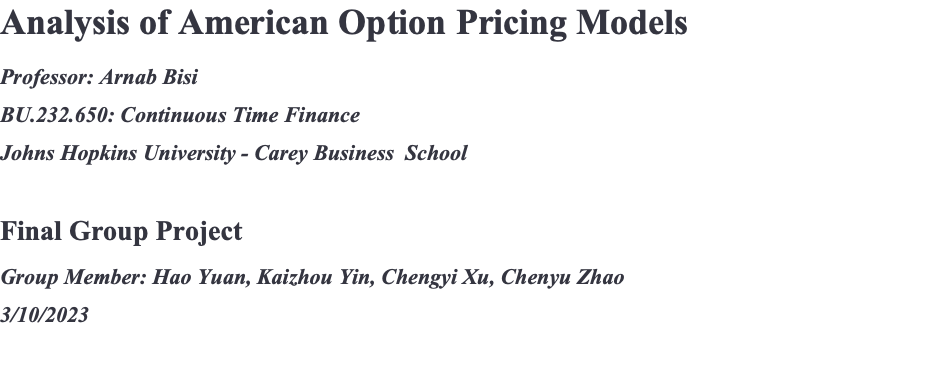

# Libraries

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import log, sqrt, exp, pi, gamma
from numpy import sign
from scipy.integrate import quad
from scipy.special import kv
import yfinance as yf
import pandas as pd

# Data

In [178]:
# Define input parameters
K = 145
r = 0.02
q = 0.01
sigma = 0.3
T = 1
phi = 1
stepSize = 100
sigmaDiff = 0.01

# Retrieve daily stock prices of Apple from Yahoo Finance
start_date = '2021-09-10'
end_date = '2023-03-08'
symbol = 'AAPL'
apple_stock = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


# Prerequisites

In [179]:
from scipy.stats import norm
from math import log, sqrt, exp
import matplotlib.pyplot as plt

def EuropeanOption(S, K, r, q, sigma, T, phi, greekCal = False):
    '''
    Calculation of Euro option price and greeks
    '''
    delta = None
    gamma = None
    theta = None
    vega = None

    top = log(S/K) + (r - q + sigma**2/2)*T
    bottom = sigma * sqrt(T)
    d1 = top/bottom
    d2 = d1 - sigma * sqrt(T)

    b1 = exp(-q*T)
    b2 = exp(-r*T)

    if greekCal:
        gamma = b1 * norm.pdf(d1)/(S * bottom)
        vega = b1 * S * norm.pdf(d1) * sqrt(T)

    if  phi == 1:
        nd1 = norm.cdf(d1)
        nd2 = norm.cdf(d2)
        price = S * b1 * nd1 - K * b2 * nd2
        if greekCal:
            delta = b1 * nd1
            theta = -b1 * S * norm.pdf(d1) * sigma / (2*sqrt(T)) - r * K * b2 * nd2 + q * S * b1 * nd1

    elif phi == -1:
        nNd1 = norm.cdf(-d1)
        nNd2 = norm.cdf(-d2)
        price = K * b2 * nNd2 - S * b1 * nNd1
        if greekCal:
            delta = -b1 * nNd1
            theta = -b1 * S * norm.pdf(d1) * sigma / (2*sqrt(T)) + r * K * b2 * nNd2 - q * S * b1 * nNd1

    return price, delta, gamma, theta, vega

# Input variables

In [180]:
# Define input parameters
K = 145
r = 0.02
q = 0.01
sigma = 0.3
T = 1
phi = 1
stepSize = 100
sigmaDiff = 0.01

# Retrieve daily stock prices of Apple from Yahoo Finance
start_date = '2021-09-10'
end_date = '2023-03-08'
symbol = 'AAPL'
apple_stock = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


# Binomial (True Value)

In [181]:
#True Value
def mainBinomial(S, K, r, q, sigma, T, phi, stepSize, sigmaDiff):
    '''
    Main function for binomial tree
    '''
    def doubleTest(S, K, r, q, sigma, T, phi, stepSize):
        result1 = AmerBinomialTree(S, K, r, q, sigma, T, phi, stepSize)
        result2 = AmerBinomialTree(S, K, r, q, sigma, T, phi, stepSize + 1)
        return [(x+y)/2 for x, y in zip(result1, result2)]

    amerPrice, amerDelta, amerGamma, amerTheta = doubleTest(S, K, r, q, sigma, T, phi, stepSize)
    lowerPrice = doubleTest(S, K, r, q, sigma-sigmaDiff, T, phi, stepSize)[0]
    upperPrice = doubleTest(S, K, r, q, sigma+sigmaDiff, T, phi, stepSize)[0]
    amerVega = (upperPrice - lowerPrice)/(2*sigmaDiff)
    amerPrice = float('%.3f' % amerPrice)
    amerDelta = float('%.3f' % amerDelta)
    amerGamma = float('%.3f' % amerGamma)
    amerVega = float('%.3f' % amerVega)
    amerTheta = float('%.3f' % amerTheta)
    return amerPrice, amerDelta, amerGamma, amerTheta, amerVega

def AmerBinomialTree(S, K, r, q, sigma, T, phi, stepSize):
    deltaT = T/stepSize
    stockPriceTree = np.zeros((stepSize+1, stepSize+1))
    stockPriceTree[0, 0] = S
    optionPriceTree = np.zeros((stepSize+1, stepSize+1))
    u = exp(sigma * sqrt(deltaT))
    d = 1/u
    rfRate = exp(r*deltaT)
    p = (rfRate * exp(-q*deltaT) - d)/(u-d)
    # Form stock tree
    for index in range(1, stepSize+1):
        stockPriceTree[index, index] = stockPriceTree[index-1, index-1] * u
    for i in range(stepSize + 1):
        for j in range(i+1, stepSize + 1):
            stockPriceTree[i, j] = stockPriceTree[i, j-1] * d
    # Construct Option Tree:
    optionPriceTree[:, -1] = np.maximum(phi * (stockPriceTree[:, -1] - K), 0)
    for j in range(stepSize-1, -1, -1):
        for i in range(j+1):
            val = (p * optionPriceTree[i+1,j+1] + (1-p) * optionPriceTree[i, j+1])/rfRate
            if val < phi * (stockPriceTree[i, j] - K):
                val = phi * (stockPriceTree[i, j] - K)
            optionPriceTree[i, j] = val
    # Greeks calculation
    ''' delta = (Cu-Cd)/(Su-Sd)'''
    delta = (optionPriceTree[1, 1] - optionPriceTree[0, 1])/(stockPriceTree[1, 1] - stockPriceTree[0, 1])
    '''delta1 = (Cuu-Cud)/(Suu-S), delta2 = (Cud-Cdd)/(S-Sdd), deltaH = 0.5(Suu+S) - 0.5(S-Sdd), gamma = (delta1-delta2)/deltaH'''
    gamma = ((optionPriceTree[2, 2]-optionPriceTree[1, 2])/(stockPriceTree[2, 2] - stockPriceTree[1, 2]) - (optionPriceTree[1, 2]-optionPriceTree[0, 2])/(stockPriceTree[1, 2] - stockPriceTree[0, 2]))/(0.5*(stockPriceTree[2, 2] - stockPriceTree[0, 2] ))
    '''theta = (Cud - C)(2 deltaT)'''
    theta = (optionPriceTree[1, 2]-optionPriceTree[0, 0])/(2*deltaT)
    return optionPriceTree[0, 0], delta, gamma, theta

# Table

In [182]:
data1 = []
# Create table
for price in apple_stock['Adj Close']:
    amerPrice, amerDelta, amerGamma, amerTheta, amerVega = mainBinomial(price, K, r, q, sigma, T, phi, stepSize, sigmaDiff)
    row = {'Price': price, 'True Price': amerPrice, 'Delta': amerDelta, 'Gamma': amerGamma, 'Theta': amerTheta, 'Vega': amerVega}
    data1.append(row)

TRUE = pd.DataFrame(data1)

# Print the table
print(TRUE)

          Price  True Price  Delta  Gamma  Theta    Vega
0    147.669083      19.321  0.591  0.009 -9.016  56.724
1    148.244019      19.658  0.596  0.009 -9.027  56.810
2    146.826492      18.826  0.583  0.009 -8.999  56.597
3    147.728546      19.355  0.591  0.009 -9.017  56.733
4    147.490646      19.216  0.589  0.009 -9.012  56.697
..          ...         ...    ...    ...    ...     ...
369  145.309998      17.937  0.570  0.009 -8.968  56.369
370  145.910004      18.289  0.575  0.009 -8.980  56.459
371  151.029999      21.353  0.619  0.008 -9.050  56.663
372  153.830002      23.101  0.642  0.008 -9.051  56.758
373  151.600006      21.709  0.624  0.008 -9.050  56.746

[374 rows x 6 columns]


# Whaley

In [183]:
#Whaley
def BAWPrice(S, K, r, q, sigma, T, phi):
    '''
    '''
    if phi == 1 and q == 0:
        return EuropeanOption(S, K, r, q, sigma, T, phi, greekCal = True)
    euroPrice = EuropeanOption(S, K, r, q, sigma, T, phi, greekCal = False)[0]
    beta = 2 * (r-q)/(sigma**2) # N in paper
    alpha = 2 * r / (sigma**2) # M
    h = 1 - exp(-r*T) # K in paper
    lambdaH = (1-beta + phi * sqrt((beta-1)**2 + 4*alpha/h))/2
    lammbdaInf = (1-beta + phi * sqrt((beta-1)**2 + 4*alpha))/2
    sxInfty = K / (1 - 1/lammbdaInf)
    hI = -((r-q)*T + 2*phi * sigma * sqrt(T)) * K / (sxInfty-K)
    initialGuess = sxInfty + (K - sxInfty) * exp(hI)
    Sx = findSx(initialGuess, K, r, q, sigma, T, lambdaH, phi)
    d1 = (log(Sx / K) + (r - q + sigma ** 2 / 2)*T) / (sigma * sqrt(T))
    A = phi * (Sx / lambdaH) * (1 - exp(-q*T) * norm.cdf(phi*d1))
    if phi*(Sx-S) > 0:
        amerPrice = euroPrice + A * (S/Sx)**lambdaH
    else:
        amerPrice = phi * (S-K)
    amerDelta, amerGamma, amerTheta, amerVega = greeksAnalysis(S, K, r, q, sigma, T, phi, Sx, A, d1, lambdaH, beta, alpha, h, amerPrice)
    amerPrice = float('%.3f' % amerPrice)
    amerDelta = float('%.3f' % amerDelta)
    amerGamma = float('%.3f' % amerGamma)
    amerVega = float('%.3f' % amerVega)
    amerTheta = float('%.3f' % amerTheta)
    euroPrice = float('%.3f' % euroPrice)
    return amerPrice, amerDelta, amerGamma, amerTheta, amerVega, amerPrice - euroPrice

def findSx(initialGuess, K, r, q, sigma, T, lambdaH, phi):
    '''
    Use  method in paper for estimating Sx (page 309)
    '''
    finish = False
    countCycle = 0
    while (not finish):
        d1 = (log(initialGuess / K) + (r - q + sigma ** 2 / 2) * T)/(sigma * sqrt(T))
        euroPrice, delta = EuropeanOption(initialGuess, K, r, q, sigma, T, phi, True)[0:2]
        leftSide = (initialGuess - K) * phi
        rightSide = euroPrice + phi * initialGuess * (1 - exp(-q*T) * norm.cdf(phi*d1)) / lambdaH
        if abs(leftSide - rightSide) / K < 0.0000001:
            finish = True
        else:
            slopeBi = delta * (1 - 1/lambdaH) + phi * (1 - phi * exp(-q*T) * norm.pdf(phi*d1)/(sigma * sqrt(T))) / lambdaH
            initialGuess = (K + phi * rightSide - phi * slopeBi * initialGuess)/(1 - phi * slopeBi)
            countCycle += 1
    return initialGuess

def greeksAnalysis(S, K, r, q, sigma, T, phi, Sx, A, d1Sx, lambdaH, beta, alpha, h, amerPrice):
    euroPriceS, deltaS, gammaS, thetaS, vegaS = EuropeanOption(S, K, r, q, sigma, T, phi, greekCal=True)
    if phi * (Sx - S) > 0:
        euroPriceSx, deltaSx, gammaSx, thetaSx, vegaSx = EuropeanOption(Sx, K, r, q, sigma, T, phi, greekCal=True)
        amerDelta = deltaS + A * lambdaH * (S**(lambdaH-1)) / (Sx**lambdaH)
        amerGamma = gammaS + A * lambdaH * (lambdaH - 1) * (S**(lambdaH-2)) / (Sx**lambdaH)
        amerTheta = r * amerPrice - (sigma*S)**2 * amerGamma / 2 - (r-q) * S * amerDelta
        # Vega
        alphaP = - 2 * alpha / sigma
        betaP = - 2 * beta / sigma
        lambdaP = 0.5 * (-betaP + 0.5 * phi * (2*(beta-1)*betaP + 4 * alphaP/h)/(sqrt((beta-1)**2 + 4 * alpha / h)))
        numeratorForSxP = vegaSx - Sx * exp(-q*T) * norm.pdf(d1Sx) * (sqrt(T) - d1Sx/sigma) / lambdaH - (phi - deltaSx) * Sx * lambdaP / (lambdaH**2)
        denominatorSxP = phi - deltaSx + exp(-q*T) * norm.pdf(d1Sx) / (lambdaH*sigma*sqrt(T)) - (phi - deltaSx)/lambdaH
        SxP = numeratorForSxP / denominatorSxP
        d1SxP = SxP/(Sx * sigma * sqrt(T)) + sqrt(T) - d1Sx/sigma
        AP = (SxP / lambdaH - Sx * lambdaP / (lambdaH**2)) * (phi - deltaSx) - exp(-q*T) * norm.pdf(phi*d1Sx) * d1SxP * (Sx/lambdaH)
        amerVega = vegaS + ((S/Sx)**lambdaH) * (AP + A * (lambdaP * log(S/Sx) - lambdaH * SxP / Sx))
    else:
        amerDelta = phi
        amerGamma = 0
        amerTheta = 0
        amerVega = 0

    return amerDelta, amerGamma, amerTheta, amerVega

## Table

In [184]:
# Get daily stock prices of
applePrices = yf.download('AAPL', start='2021-09-10', end='2023-03-08')['Adj Close']

# Create a table of the columns 
WHALEY = pd.DataFrame(columns=['Price','whaleyprice', 'Delta', 'Gamma', 'Theta', 'Vega'])

# Loop over each date in applePrices and calculate price for that date
for date, price in applePrices.items():
    amerPrice, amerDelta, amerGamma, amerTheta, amerVega, bawPrice = BAWPrice(price, K=145, r=0.02, q=0.01, sigma=0.3, T=1, phi=1)
    WHALEY = WHALEY.append({
        'Price': price,
        'whaleyprice': amerPrice,
        'Delta': amerDelta,
        'Gamma': amerGamma,
        'Theta': amerTheta,
        'Vega': amerVega,
    }, ignore_index=True)

# Print the table
print(WHALEY)

[*********************100%***********************]  1 of 1 completed


/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/711582917.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WHALEY = WHALEY.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/711582917.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WHALEY = WHALEY.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/711582917.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WHALEY = WHALEY.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/711582917.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WHALEY = WHALEY.append({
/var/folders/m6/wxc9fp790875bb7z

          Price  whaleyprice  Delta  Gamma  Theta    Vega
0    147.669083       19.308  0.591  0.009 -8.985  56.702
1    148.244019       19.649  0.596  0.009 -8.994  56.739
2    146.826492       18.813  0.583  0.009 -8.968  56.629
3    147.728561       19.343  0.591  0.009 -8.986  56.706
4    147.490646       19.202  0.589  0.009 -8.982  56.688
..          ...          ...    ...    ...    ...     ...
369  145.309998       17.938  0.570  0.009 -8.930  56.446
370  145.910004       18.282  0.575  0.009 -8.946  56.526
371  151.029999       21.341  0.619  0.008 -9.020  56.788
372  153.830002       23.107  0.642  0.008 -9.012  56.623
373  151.600006       21.696  0.624  0.008 -9.021  56.772

[374 rows x 6 columns]


/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/711582917.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WHALEY = WHALEY.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/711582917.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WHALEY = WHALEY.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/711582917.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WHALEY = WHALEY.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/711582917.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WHALEY = WHALEY.append({
/var/folders/m6/wxc9fp790875bb7z

# Ju Zhong

In [185]:
# juzhong model
def JuZhongPrice(S, K, r, q, sigma, T, phi):
    '''
    American option calculation based on Ju-Zhong paper
    '''
    if phi == 1 and q == 0:
        return EuropeanOption(S, K, r, q, sigma, T, phi, greekCal = True)
    alpha = 2 * r/(sigma**2)
    beta = 2 * (r-q)/(sigma**2)
    hTau = 1 - exp(-r*T)
    lambdaH = (-(beta-1) + phi * sqrt((beta-1)**2 + 4 * alpha/hTau))/2

    qInfty =  (1 - beta + phi * sqrt((beta - 1)**2 + 4*alpha))/2
    sInfty = K/(1 - 1/qInfty)
    hi = (-phi*(r-q)*T - 2*sigma*sqrt(T)) * K / (phi * (sInfty - K))
    initialGuess = sInfty + (K - sInfty) * exp(hi)
    Sx = findSx(initialGuess, K, r, q, sigma, T, phi, lambdaH)
    ah = (phi * (Sx - K) - EuropeanOption(Sx, K, r, q, sigma, T, phi=phi)[0])/hTau

    theta = EuropeanOption(Sx, K, r, q, sigma, T, phi=phi, greekCal=True)[-2]
    lambdaHDerivation = -phi * alpha / (hTau**2 * sqrt((beta -1)**2 + 4*alpha/hTau))
    b = (1 - hTau) * alpha * lambdaHDerivation/(2*(2 * lambdaH + beta - 1))
    c = - (1 - hTau) * alpha / (2 * lambdaH + beta - 1) * (-theta/(hTau * ah * r * exp(-r*T)) + 1/hTau + lambdaHDerivation/(2 * lambdaH + beta - 1))
    euroPrice = EuropeanOption(S, K, r, q, sigma, T, phi=phi)[0]
    if phi * (Sx - S) > 0:
        amerPrice = euroPrice + (hTau * ah * (S/Sx)**lambdaH)/(1 - b * (log(S/Sx))**2 - c * log(S/Sx))
    else:
        amerPrice = phi * (S - K)
    amerDelta, amerGamma, amerTheta, amerVega = greeksAnalysis(S, K, r, q, sigma, T, phi, Sx, ah, lambdaH, beta, alpha, hTau, b, c, amerPrice)
    amerPrice = float('%.3f' % amerPrice)
    amerDelta = float('%.3f' % amerDelta)
    amerGamma = float('%.3f' % amerGamma)
    amerVega = float('%.3f' % amerVega)
    amerTheta = float('%.3f' % amerTheta)
    euroPrice = float('%.3f' % euroPrice)
    return amerPrice, amerDelta, amerGamma, amerTheta, amerVega, amerPrice - euroPrice

def findSx(initialGuess, K, r, q, sigma, T, phi, lambdaH):
    finish = False
    countCycle = 0
    while (not finish):
        d1 = (log(initialGuess / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * sqrt(T))
        euroPrice, delta = EuropeanOption(initialGuess, K, r, q, sigma, T, phi=phi, greekCal=True)[0:2]
        leftSide = phi * initialGuess - lambdaH * (phi * (initialGuess - K))
        rightSide = phi * initialGuess * exp(-q*T) * norm.cdf(phi*d1) - euroPrice * lambdaH
        # difference = phi * exp(-q*T) * norm.cdf(phi*d1) + lambdaH * (phi*(initialGuess-K) - euroPrice)/initialGuess - phi
        if abs(leftSide - rightSide) / K < 0.0000001:
            finish = True
        else:
            slopeBi = exp(-q*T) * norm.pdf(phi*d1) /(sigma*sqrt(T)) + (1 - lambdaH) * delta
            initialGuess = (lambdaH * K * phi + initialGuess * slopeBi - rightSide)/(slopeBi - phi * (1-lambdaH))
            countCycle += 1
    return initialGuess

def greeksAnalysis(S, K, r, q, sigma, T, phi, Sx, A, lambdaH, beta, alpha, h, b, c, amerPrice):
    euroPriceS, deltaS, gammaS, thetaS, vegaS = EuropeanOption(S, K, r, q, sigma, T, phi, greekCal=True)
    if phi * (Sx - S) > 0:
        euroPriceSx, deltaSx, gammaSx, thetaSx, vegaSx = EuropeanOption(Sx, K, r, q, sigma, T, phi, greekCal=True)
        d1Sx = (log(Sx / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * sqrt(T))
        d2Sx = d1Sx - sigma * sqrt(T)
        d1S = (log(S / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * sqrt(T))
        chi = b * (log(S/Sx))**2 + c * log(S/Sx)
        chiPS = (2 * b / S) * log(S/Sx) + c / S
        chiPSS = (2 * b / (S**2)) * (1 - log(S/Sx)) - c / (S**2)
        amerDelta = deltaS + (lambdaH/(S*(1-chi)) + chiPS/((1-chi)**2)) * (phi * (Sx - K) - euroPriceSx) * ((S/Sx)**lambdaH)
        amerGamma = exp(-q*T) * norm.pdf(phi*d1S) / (S * sigma * sqrt(T)) + (2 * lambdaH * chiPS / (S*(1-chi)**2) + 2 * chiPS**2 / ((1-chi)**3) + chiPSS / (1-chi)**2 + (lambdaH**2 - lambdaH)/(S**2 * (1-chi))) * (phi * (Sx - K) - euroPriceSx) * ((S/Sx)**lambdaH)
        amerTheta = r * amerPrice - (sigma*S)**2 * amerGamma / 2 - (r-q) * S * amerDelta
        # Vega
        '''
        paramLambda = (beta-1)**2 + 4 * alpha / h
        alphaP = - 2 * alpha / sigma
        betaP = - 2 * beta / sigma
        lambdaP = 0.5 * (-betaP + 0.5 * phi * (2*(beta-1)*betaP + 4 * alphaP/h)/(sqrt(paramLambda)))
        lambdaPh = - phi * alpha / (h**2 * sqrt(paramLambda))
        lambdaPhP = - (phi / (h**2)) * (alphaP/sqrt(paramLambda) - (alpha/2)*(2*(beta-1)*betaP + 4 * alphaP/h)/(paramLambda)**(3/2))
        bP = ((1-h)/2) * ((lambdaPh * alphaP + alpha * lambdaPhP) / (2*lambdaH + beta - 1) - alpha * lambdaPh * (2 * lambdaP + betaP) / (2*lambdaH + beta - 1)**2)
        numeratorForSxP = phi * (Sx - K) * lambdaP + Sx * exp(-q*T) * norm.pdf(d1Sx) * (sqrt(T) - d1Sx/sigma) - euroPriceSx * lambdaP - lambdaH * vegaSx
        denominatorSxP = phi - phi * lambdaH - deltaSx - exp(-q*T) * norm.pdf(d1Sx) / (sigma * sqrt(T)) + lambdaH * deltaSx
        SxP = numeratorForSxP / denominatorSxP
        d1SxP = SxP / (Sx * sigma * sqrt(T)) + (sqrt(T) - d1Sx / sigma)
        d2SxP = d1SxP - sqrt(T)
        AP = ((phi - deltaSx) * SxP - vegaSx) / h
        thetaP = - (exp(-q*T)/(2*sqrt(T))) * (Sx * norm.pdf(d1Sx) + sigma * norm.pdf(d1Sx) * SxP - Sx * sigma * norm.pdf(d1Sx) * d1Sx * d1SxP) - r * K * exp(-r*T) * norm.pdf(d2Sx) * d2SxP + q * Sx * exp(-q*T) * norm.pdf(d1Sx) * d1SxP + q * deltaSx * SxP
        cP = - (1-h) / (2 * lambdaH + beta - 1) * (alphaP - alpha * (2 * lambdaP + betaP) / (2 * lambdaH + beta - 1)) * (-thetaSx / (h * r * exp(-r*T) * A) + 1/h + lambdaPh / (2 * lambdaH + beta - 1)) - (1-h) * alpha / (2 * lambdaH + beta - 1) * ((-1 / (h * r * exp(-r*T))) * (thetaP / A - thetaSx * AP / (A**2)) + lambdaPhP / (2 * lambdaH + beta - 1) - lambdaPh * (2 * lambdaP + betaP) / ((2 * lambdaH + beta - 1)**2))
        amerVega = vegaS + (h/(1-chi)) * (AP + A * (lambdaP * log(S/Sx) - lambdaH * SxP / Sx)) * ((S/Sx)**lambdaH) - ((h*A*(S/Sx)**lambdaH)/(1-chi)**2) * (-bP * (log(S/Sx))**2 + 2 * b * log(S/Sx) * SxP / Sx - cP * log(S/Sx) + c * SxP / Sx)
        '''
        paramLambda = (beta - 1) ** 2 + 4 * alpha / h
        alphaP = - 2 * alpha / sigma
        betaP = - 2 * beta / sigma
        lambdaP = 0.5 * (-betaP + 0.5 * phi * (2 * (beta - 1) * betaP + 4 * alphaP / h) / sqrt(paramLambda))
        lambdaPh = - phi * alpha / (h**2 * sqrt(paramLambda))
        lambdaPhP = - (phi / ((h**2) * sqrt(paramLambda))) * (alphaP - alpha * (2 * (beta - 1) * betaP + 4 * alphaP / h) / (2 * paramLambda))
        bP = (1-h) * (lambdaPh * alphaP + alpha * lambdaPhP - alpha * lambdaPh * (2 * lambdaP + betaP) / (2 * lambdaH + beta - 1)) / (2 * (2 * lambdaH + beta - 1))
        numeratorForSxP = Sx * exp(-q*T) * norm.pdf(d1Sx) * (sqrt(T) - d1Sx / sigma) + (phi * (Sx - K) - euroPriceSx) * lambdaP - lambdaH * vegaSx
        denominatorSxP = (1 - lambdaH) * (phi - deltaSx) - exp(-q*T) * norm.pdf(d1Sx) / (sigma * sqrt(T))
        SxP = numeratorForSxP / denominatorSxP
        d1SxP = SxP / (Sx * sigma * sqrt(T)) + (sqrt(T) - d1Sx / sigma)
        d2SxP = d1SxP - sqrt(T)
        AP = (SxP * (phi - deltaSx) - vegaSx) / h
        thetaP = - exp(-q*T) * norm.pdf(d1Sx) * (Sx + sigma * SxP - Sx * sigma * d1Sx * d1SxP) / (2 * sqrt(T)) - r * K * exp(-r*T) * norm.pdf(d2Sx) * d2SxP + q * Sx * exp(-q*T) * norm.pdf(d1Sx) * d1SxP + q * deltaSx * SxP
        cP = - ((1-h) * alpha / (2 * lambdaH + beta - 1)) * (-(thetaP / A - thetaSx * AP / (A**2)) / (h * r * exp(-r*T)) + lambdaPhP / (2 * lambdaH + beta - 1) - lambdaPh * (2 * lambdaP + betaP) / ((2 * lambdaH + beta - 1)**2)) - (1-h) * (-thetaSx / (h * r * exp(-r*T) * A) + 1 / h + lambdaPh / (2 * lambdaH + beta - 1)) * (alphaP / (2 * lambdaH + beta - 1) - alpha * (2 * lambdaP + betaP) / ((2 * lambdaH + beta - 1)**2))
        chiP = bP * ((log(S/Sx))**2) - (2 * b * (log(S/Sx)) + c) * SxP / Sx + cP * (log(S/Sx))
        amerVega = vegaS + (h * ((S/Sx)**lambdaH) / (1 - chi)) * (AP + A * (lambdaP * (log(S/Sx)) - lambdaH * SxP / Sx)) + h * A * ((S/Sx)**lambdaH) *chiP / ((1 - chi)**2)

    else:
        amerDelta = phi
        amerGamma = 0
        amerTheta = 0
        amerVega = 0
    return amerDelta, amerGamma, amerTheta, amerVega

# Table

In [186]:
# Get daily stock prices of Apple from 2019/1/1 to 2020/12/1
applePrices = yf.download('AAPL', start='2021-09-10', end='2023-03-08')['Adj Close']

# Create a table of the columns for JW
JZ = pd.DataFrame(columns=['Price','whaleyprice', 'Delta', 'Gamma', 'Theta', 'Vega'])

# Loop over each date in applePrices and calculate the BAWPrice for that date
for date, price in applePrices.items():
    amerPrice, amerDelta, amerGamma, amerTheta, amerVega, bawPrice = JuZhongPrice(price, K=145, r=0.02, q=0.01, sigma=0.3, T=1, phi=1)
    JZ = JZ.append({
        'Price': price,
        'whaleyprice': amerPrice,
        'Delta': amerDelta,
        'Gamma': amerGamma,
        'Theta': amerTheta,
        'Vega': amerVega,
    }, ignore_index=True)

# Print the table
print(JZ)

[*********************100%***********************]  1 of 1 completed


/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/2467665528.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  JZ = JZ.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/2467665528.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  JZ = JZ.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/2467665528.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  JZ = JZ.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/2467665528.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  JZ = JZ.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_6

          Price  whaleyprice  Delta  Gamma  Theta    Vega
0    147.669067       19.302  0.591  0.009 -8.981  56.646
1    148.244034       19.643  0.596  0.009 -8.991  56.683
2    146.826492       18.808  0.583  0.009 -8.965  56.574
3    147.728561       19.338  0.591  0.009 -8.982  56.650
4    147.490646       19.197  0.589  0.009 -8.978  56.632
..          ...          ...    ...    ...    ...     ...
369  145.309998       17.934  0.570  0.009 -8.927  56.392
370  145.910004       18.277  0.575  0.009 -8.943  56.472
371  151.029999       21.336  0.619  0.008 -9.016  56.728
372  153.830002       23.101  0.642  0.008 -9.008  56.560
373  151.600006       21.690  0.624  0.008 -9.017  56.711

[374 rows x 6 columns]


/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/2467665528.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  JZ = JZ.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/2467665528.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  JZ = JZ.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/2467665528.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  JZ = JZ.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_61467/2467665528.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  JZ = JZ.append({
/var/folders/m6/wxc9fp790875bb7z5jw_q5c80000gn/T/ipykernel_6

# Our model

## VG updated

In [187]:
def VGEuro(S, K, nu, theta, sigma, r, q, T, phi):
    '''
    phi = 1: call; phi = -1: Put
    '''

    c = T/nu
    omega = log(1 - nu * theta - (sigma**2) * nu / 2)/nu
    zeta = (log(S/K) + omega * T)/sigma
    v = 1 - nu * (theta + sigma**2 / 2)
    a1 = zeta * sqrt(v/nu)
    b1 = (theta + sigma**2)*sqrt(nu/v) / sigma
    a2 = zeta * sqrt(1/nu)
    b2 = theta * sqrt(nu)/sigma
    euroCall = S * exp(-q * T) * Phi(a1, b1, c) - K * exp(-r * T) * Phi(a2, b2, c)


    if phi == 1:
        return euroCall
    else:
        return euroCall - (S * exp(-q*T) - K * exp(-r*T))

def Phi(a, b, gammaPhi):
    u = b / sqrt(2+b**2)
    c = abs(a) * sqrt(2 + b**2)
    phi1 = hyperGM(gammaPhi, 1 - gammaPhi, 1 + gammaPhi, (1+u)/2, -sign(a)*c*(1+u))
    phi2 = hyperGM(1+gammaPhi, 1 - gammaPhi, 2+gammaPhi, (1+u)/2, -sign(a)*c*(1+u))
    param1 = (c**(gammaPhi+0.5) * exp(sign(a)*c) * (1+u)**gammaPhi) / (sqrt(2*pi)*gamma(gammaPhi)*gammaPhi)
    param2 = (c**(gammaPhi+0.5) * exp(sign(a)*c) * (1+u)**(1+gammaPhi)) / (sqrt(2*pi)*gamma(gammaPhi)*(gammaPhi+1))
    return param1 * phi1 * kv(gammaPhi+0.5, c) - sign(a) * param2 * kv(gammaPhi-0.5, c) * phi2 + sign(a)*param1*kv(gammaPhi-0.5, c)*phi1

def hyperGM(alpha, beta, gam, x, y):
    intSol = 0
    integrandL = 0
    for i in range(1, 100001):
        deltaU = 1 / 100000
        u = deltaU * i
        if i != 1:
            integrandL = integrandH
        if 1 - u != 0:
            integrandH = (u**(alpha-1)) * ((1-u)**(gam - alpha - 1)) * ((1 - u * x)**(-beta)) * exp(u*y)
        else:
            integrandH = (u ** (alpha - 1)) * ((1 + deltaU/2 - u) ** (gam - alpha - 1)) * ((1 - u * x) ** (-beta)) * exp(u * y)
        intSol += (integrandL + integrandH) * deltaU / 2
    return (intSol * gamma(gam)) / (gamma(alpha) * gamma(gam - alpha))

def VGPrice(S, K, nu, theta, sigma, r, q, T, phi):
    def expint(lowerBound):
        def integrand(y):
            return exp(-y) / y
        return quad(integrand, lowerBound, np.inf)[0]
    lambdaP = sqrt((theta**2)/(sigma**4) + 2/(sigma**2 * nu)) - theta/(sigma**2)
    lambdaN = lambdaP + 2 * theta/(sigma**2)

    epsilon = S/8000
    sigmaEpsilon = sqrt((1 - exp(-lambdaP*epsilon) * (epsilon*lambdaP + 1)) / (nu * (lambdaP**2)) + (1 - exp(-lambdaN*epsilon) * (epsilon*lambdaN + 1)) / (nu * (lambdaN**2)))
    omegaEpsilon = expint(epsilon * lambdaP) / nu - expint(epsilon * (lambdaP - 1)) / nu + expint(epsilon * lambdaN) / nu - expint(epsilon * (lambdaN + 1)) / nu
    return JuZhongPrice(S, K, r, q-omegaEpsilon, sigmaEpsilon, T, phi)[-1], VGEuro(S, K, nu, theta, sigma, r, q, T, phi)
    #return JuZhongPrice(S, K, r, q-omegaEpsilon, sigmaEpsilon, T, phi)[0]



def paramEva(S,nu, theta, sigma, r, q, T):
    def expint(lowerBound):
        def integrand(y):
            return exp(-y) / y
        return quad(integrand, lowerBound, np.inf)[0]
    lambdaP = sqrt((theta**2)/(sigma**4) + 2/(sigma**2 * nu)) - theta/(sigma**2)
    lambdaN = lambdaP + 2 * theta/(sigma**2)
    epsilonList = [i/100 for i in range(200)]
    sigmaList = []
    omegaList = []
    for epsilon in epsilonList:
        sigmaEpsilon = sqrt((1 - exp(-lambdaP*epsilon) * (epsilon*lambdaP + 1)) / (nu * (lambdaP**2)) + (1 - exp(-lambdaN*epsilon) * (epsilon*lambdaN + 1)) / (nu * (lambdaN**2)))
        omegaEpsilon = expint(epsilon * lambdaP) / nu - expint(epsilon * (lambdaP - 1)) / nu + expint(epsilon * lambdaN) / nu - expint(epsilon * (lambdaN + 1)) / nu
        sigmaList.append(sigmaEpsilon)
        omegaList.append(omegaEpsilon)
    #plt.plot(epsilonList, sigmaList, 'o')
    plt.plot(epsilonList, omegaList, 'or')
    plt.title('T = {}'.format(T))
    plt.xlabel('epsilon')
    #plt.ylabel('sigma')
    plt.ylabel('omega')
    plt.legend(loc='upper left')
    plt.show()

### early premium

In [188]:
#our model
def earlyExecerisePremium(S0,r,q,sigma,nu,theta,T,phi, strikeList):
    outPutEuro = []
    outPutAmer = []
    outPutEarly = []
    
    K = strikeList # set K as the value of strikeList
    
    earlyExecerise, euroValue = VGPrice(S0,K,nu,theta,sigma,r,q,T,phi)
    earlyExecerise = float('%.4f' % earlyExecerise)
    euroValue = float('%.4f' % euroValue)
    outPutEuro.append(euroValue)
    outPutAmer.append(earlyExecerise + euroValue)
    outPutEarly.append(earlyExecerise)
    
    return outPutAmer

In [189]:
# Set the parameters
K = 145
r = 0.02
q = 0.01
sigma = 0.3
T = 1
nu = 0.5
phi = 1

# Get the stock price data using yfinance
apple = yf.download("AAPL", start="2019-01-01", end="2020-12-01")
S0 = apple['Adj Close']

theta = TRUE.iloc[:, 4]

# Create a list to store the output values
outPutAmer_list = []

[*********************100%***********************]  1 of 1 completed
